HW3

The code is slow to run due to the for-loop being slow in Python. 

Consider problem 2c). To save time, the random sample is drawn in batch at the first iteration. Then, the following iterations access outcomes from this batch. A single time step takes roughly 0.0025s. (The first one takes 0.125). With a mesh size of N=100, we have 0.25s for a single function realization. Thus, just nsteps=1000 in the MC-computation takes over 4 minutes!

Therefore, I will complete the exercise with lower-than-customary accuracy. In problem 2d), I will use TOL=$2$, TOL = $1$ instead of the values specified by the instruction.

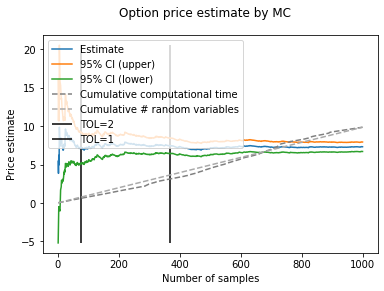

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import logging
import scipy.stats
import copy

In [43]:
with open('logs.log', 'w'):
    pass
logging.basicConfig(filename='logs.log', level=logging.INFO)

In [44]:
with open("logs.log") as log:
    print(log.read())

In [45]:
nvars = {}
nvars_storage = {}

def clean_nvars():
    global nvars
    nvars = {}

def nvar(loc=0, scale=1):
  global nvars_storage
  global nvars
  params = str(locals())
  if params not in nvars.keys():
     if params not in nvars_storage.keys():
        nvars_storage[params] = []
        nvars[params] = []
     else:
        nvars[params] = copy.copy(nvars_storage[params])
  if not nvars[params]:
    refill = list(np.random.normal(size=10**6, loc=loc, scale=scale))
    nvars[params] = refill
    nvars_storage[params].extend(refill)
  W = nvars[params][0]
  nvars[params].pop(0)
  return W

In [46]:
def mc(func, nsteps=1000, **kwargs):
  clean_nvars()
  y = []
  s2 = []
  t = []
  spld = []
  x = range(1,nsteps+1)
  start_time = time.time()
  for nsteps in x:
    q = time.time()
    price, rvs = func(**kwargs)
    logging.info(f"time for realization: {time.time()-q}")
    if not y:
      y.append(price)
      s2.append(0)
      spld.append(rvs)
    else:
      y.append((y[-1]*(nsteps-1)+price)/nsteps)
      s2.append(1/(nsteps-1)*(s2[-1]*(nsteps-2)+(nsteps-1)*y[-2]**2+price**2-nsteps*y[-1]**2))
      spld.append(rvs+spld[-1])
    elapsed_time = time.time()-start_time
    logging.info(f"total time for outcome: {time.time()-q}")
    t.append(elapsed_time)
  return x[1:], y[1:], s2[1:], t[1:], spld[1:]

Problem 1a

In [47]:
def f(T=1/2,K=35,S0=35,r=0.04,sigma=0.2):
  q=time.time()  
  W = nvar(scale=np.sqrt(T))
  logging.info(f"sample time expenditure {time.time()-q}")
  St = np.exp((r-sigma**2/2)*T+sigma*W)*S0
  return np.exp(-r*T)*max(St-K,0), 1

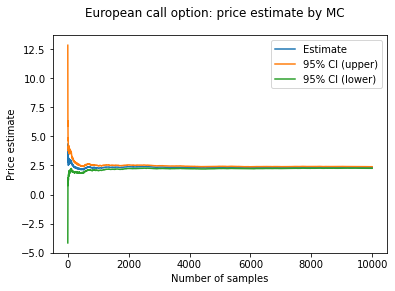

In [51]:
nsteps = 10**4
x, y, s2, t, spld = mc(func=f,nsteps=nsteps)
upper = [y[i] + 1.96*np.sqrt(s2[i]/x[i]) for i in range(len(x))]
lower = [y[i] - 1.96*np.sqrt(s2[i]/x[i]) for i in range(len(x))]
plt.plot(x,y, label="Estimate")
plt.plot(x,upper, label="95% CI (upper)")
plt.plot(x,lower, label="95% CI (lower)")
#plt.xlim((1,2000))
#plt.ylim((-5,5))
plt.xlabel("Number of samples")
plt.ylabel("Price estimate")
plt.suptitle("European call option: price estimate by MC")
plt.legend()

In [52]:
print(f"Estimate: {np.round(y[-1],3)} ({np.round(lower[-1],3)},{np.round(upper[-1],3)}) with {x[-1]} samples")

Estimate: 2.324 (2.256,2.391) with 10000 samples


Problem 1b)

In [74]:
s=35
nsteps = 10**3
x = [(1/2)**i for i in range(10)]
y, s2 = mc(func=f, nsteps=nsteps, S0=s)[1:3]
y0 = y[-1]
s20 = s2[-1]

d1p2 = []
d1p3 = []
d2p3 = []
d3p5 = []

for ds in x:
  y1 = mc(func=f,nsteps=nsteps, S0=s+ds)[1]
  y2 = mc(func=f,nsteps=nsteps, S0=s-ds)[1]
  y3 = mc(func=f,nsteps=nsteps, S0=s+2*ds)[1]
  y4 = mc(func=f,nsteps=nsteps, S0=s-2*ds)[1]
  d1p2.append((y1[-1]-y0)/ds)
  d1p3.append((y1[-1]-y2[-1])/(2*ds))
  d2p3.append((y2[-1]-2*y0+y1[-1])/(ds**2))
  d3p5.append((-y4[-1]+2*y2[-1]-2*y1[-1]+y3[-1])/(2*ds**3))

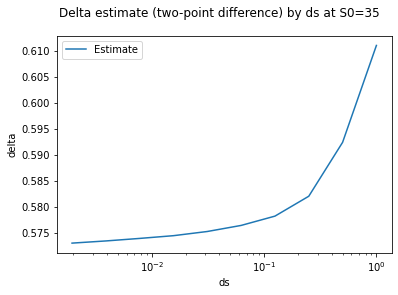

In [75]:
# Two-point difference for first derivative
plt.plot(x, d1p2, label="Estimate")
plt.xscale('log')

plt.xlabel("ds")
plt.ylabel("delta")
plt.suptitle("Delta estimate (two-point difference) by ds at S0=35")
plt.legend() 

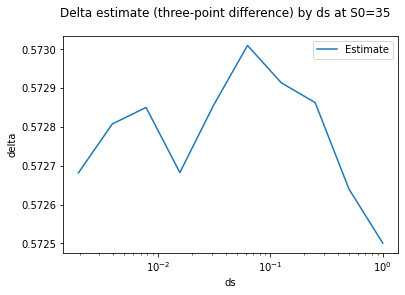

In [76]:
# Three-point difference for first derivative
plt.plot(x, d1p3, label="Estimate")
plt.xscale('log')

plt.xlabel("ds")
plt.ylabel("delta")
plt.suptitle("Delta estimate (three-point difference) by ds at S0=35")
plt.legend() 

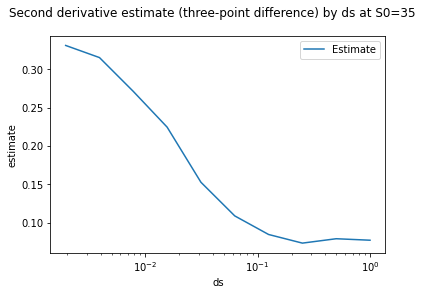

In [77]:
# Three-point difference for second derivative
plt.plot(x, d2p3, label="Estimate")
plt.xscale('log')

plt.xlabel("ds")
plt.ylabel("estimate")
plt.suptitle("Second derivative estimate (three-point difference) by ds at S0=35")
plt.legend() 

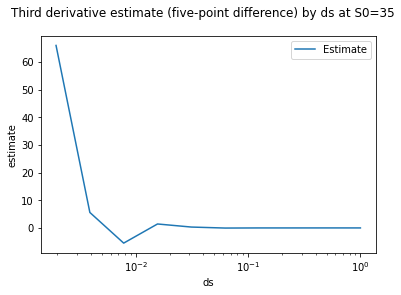

In [78]:
# Five-point difference for second derivative
plt.plot(x, d3p5, label="Estimate")
plt.xscale('log')

plt.xlabel("ds")
plt.ylabel("estimate")
plt.suptitle("Third derivative estimate (five-point difference) by ds at S0=35")
plt.legend() 

In [79]:
epsilon = 1.96*np.sqrt(s20/nsteps)
# Total error estimation
M = 1
Mtilde = 1
# Two-point difference
ep2 = 2*np.sqrt(epsilon*M)
# Three-point difference
ep3 = 1/2*(9*Mtilde*epsilon**2)**(1/3)
print(f"Two-point: {np.round(ep2,3)}, three-point {np.round(ep3,3)}")

Two-point: 0.908, three-point 0.363


In [80]:
# Delta for optimal choice of h by two-point difference
ds = np.sqrt(4*epsilon/M)
y1 = mc(func=f,nsteps=nsteps, S0=s+ds)[1]
delta_p2 = (y1[-1]-y0)/ds

# Delta for optimal choice of h by three-point difference
ds = (3*epsilon/Mtilde)**(1/3)
y1 = mc(func=f,nsteps=nsteps, S0=s+ds)[1]
y2 = mc(func=f,nsteps=nsteps, S0=s-ds)[1]
delta_p3 = (y1[-1]-y2[-1])/(2*ds)
print(f"Two-point: {np.round(delta_p2,3)}, three-point {np.round(delta_p3,3)}")

Two-point: 0.608, three-point 0.573


Problem 2c)

In [83]:
tol_1 = 2# 5*10**-2
tol_2 = 1# 5*10**-3

In [84]:
def fwd(N):
  a = 100
  r = 0.04
  T = 0.75
  Y0 = -1
  S0 = 100
  K = S0
  rho = -0.3

  dt = T/N
  S = S0
  Y = Y0
  for n in range(N):
    q=time.time()  
    dW = nvar(scale=np.sqrt(dt))
    dZ = nvar(scale=np.sqrt(dt))
    if n<3:
        logging.info(f"sample time expenditure {time.time()-q}")
    dZhat = rho*dW+np.sqrt(1-rho**2)*dZ
    S += r*S*dt+np.exp(Y)*S*dW
    Y += (-a*(2+Y)+0.4*np.sqrt(a)*np.sqrt(1-rho**2))*dt + 0.4*np.sqrt(a)*dZhat
    if n<3:
        logging.info(f"timestep time expenditure {time.time()-q}")
  return np.exp(-r*T)*max(S-K,0), 2*N

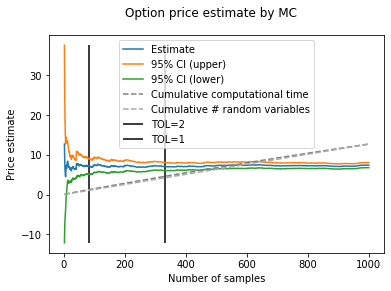

In [85]:
# Increasing samples, fixed dt
nsteps = 10**3
x, y, s2, t, spld = mc(func=fwd, nsteps=nsteps, N=100)

upper = [y[i] + 1.96*np.sqrt(s2[i]/x[i]) for i in range(len(x))]
lower = [y[i] - 1.96*np.sqrt(s2[i]/x[i]) for i in range(len(x))]
bound_1 = [x[i] for i in range(10,len(x)) if 1.96*np.sqrt(s2[i]/x[i])<=tol_1][0]
bound_2 = [x[i] for i in range(10,len(x)) if 1.96*np.sqrt(s2[i]/x[i])<=tol_2][0]

plt.plot(x,y, label="Estimate")
plt.plot(x,upper, label="95% CI (upper)")
plt.plot(x,lower, label="95% CI (lower)")

t_normalized = [s/np.max(t)*np.max(y) for s in t]
spld_normalized = [s/np.max(spld)*np.max(y) for s in spld]

plt.plot(x, t_normalized, label="Cumulative computational time", linestyle="dashed", color="grey")
plt.plot(x, spld_normalized, label="Cumulative # random variables", linestyle="dashed", color="darkgrey")
plt.vlines(bound_1, np.min(lower), np.max(upper), label=f"TOL={tol_1}", color="black")
plt.vlines(bound_2, np.min(lower), np.max(upper), label=f"TOL={tol_2}", color="black")
plt.xlabel("Number of samples")
plt.ylabel("Price estimate")
plt.suptitle("Option price estimate by MC")
plt.legend()

In [86]:
print(f"Estimate: {np.round(y[-1],2)} ({np.round(lower[-1],2)},{np.round(upper[-1],2)}) with {x[-1]} samples at c.time {np.round(t[-1],2)}s / {spld[-1]} sampled RVs")

Estimate: 7.38 (6.74,8.01) with 1000 samples at c.time 205.85s / 200000 sampled RVs


In [87]:
print(f"TOL={tol_1}: {bound_1}")
i = x.index(bound_1)
print(f"Estimate: {np.round(y[i],2)} ({np.round(lower[i],2)},{np.round(upper[i],2)}) with {x[i]} samples at c.time {np.round(t[i],2)}s / {spld[i]} sampled RVs")

TOL=2: 81
Estimate: 7.07 (5.08,9.06) with 81 samples at c.time 19.77s / 16200 sampled RVs


In [88]:
print(f"TOL={tol_2}: {bound_2}")
i = x.index(bound_2)
print(f"Estimate: {np.round(y[i],2)} ({np.round(lower[i],2)},{np.round(upper[i],2)}) with {x[i]} samples at c.time {np.round(t[i],2)}s / {spld[i]} sampled RVs")

TOL=1: 331
Estimate: 7.02 (6.03,8.02) with 331 samples at c.time 74.2s / 66200 sampled RVs


In [ ]:
# Decreasing dt, fixed samples
nsteps = 10**3
x = range(50, 250, 50)
y = []
s2 = []
t = []
spld = []
for N in x:
  xl, yl, s2l, tl, spldl = mc(func=fwd, nsteps=nsteps, N=N)
  y.append(yl[-1])
  s2.append(s2l[-1])
  t.append(tl[-1])
  spld.append(spldl[-1])

upper = [y[i] + 1.96*np.sqrt(s2[i]/nsteps) for i in range(len(x))]
lower = [y[i] - 1.96*np.sqrt(s2[i]/nsteps) for i in range(len(x))]
#bound_1 = [x[i] for i in range(len(x)) if 1.96*np.sqrt(s2[i]/nsteps)<=tol_1][0]
#bound_2 = [x[i] for i in range(len(x)) if 1.96*np.sqrt(s2[i]/nsteps)<=tol_2][0] 

plt.plot(x,y, label="Estimate")
plt.plot(x,upper, label="95% CI (upper)")
plt.plot(x,lower, label="95% CI (lower)")
t_normalized = [s/np.max(t)*np.max(y) for s in t]
spld_normalized = [s/np.max(spld)*np.max(y) for s in spld]
plt.plot(x, t_normalized, label="Cumulative computational time", linestyle="dashed", color="grey")
plt.plot(x, spld_normalized, label="Cumulative # random variables", linestyle="dashed", color="darkgrey")
#plt.vlines(bound_1, np.min(lower), np.max(upper), label="TOL=0.05", color="black")
#plt.vlines(bound_2, np.min(lower), np.max(upper), label="TOL=0.005")
plt.xlabel("Mesh size")
plt.ylabel("Price estimate")
plt.suptitle("Option price estimate by MC")
plt.legend() 

In [ ]:
print(f"Estimate: {np.round(y[-1],2)} ({np.round(lower[-1],2)},{np.round(upper[-1],2)}) with {x[-1]} mesh size at c.time {np.round(t[-1],2)}s / {spld[-1]} sampled RVs")

In [ ]:
# Why overflow for low mesh sizes (N=10,20,...,50)
# How likely to draw a high outcome from N(0,0.75) 
rv = scipy.stats.norm(0,np.sqrt(0.075))
rv.ppf(0.99995)
#2*(1-0.99995)*100